In [1]:
#pandas libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import sklearn.model_selection as modsel
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import log_loss
from sklearn.metrics import classification_report
from sklearn import tree
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
import math

%run "../notebooks/cargar_df.ipynb"

In [2]:
train = get_train()

In [3]:
test = get_test()

In [4]:
train = train[train.Stage.isin(['Closed Won', 'Closed Lost'])].copy()
train.shape

(16883, 47)

In [5]:
train.Stage.value_counts()

Closed Won     9533
Closed Lost    7350
Name: Stage, dtype: int64

In [6]:
# Me quedo con los registros con la oportunidad terminada
train.Stage.replace({'Closed Won': 1, 'Closed Lost': 0}, inplace=True)

In [7]:
train.Stage.value_counts()

1    9533
0    7350
Name: Stage, dtype: int64

In [8]:
X = pd.DataFrame({'Opportunity_ID':train.Opportunity_ID.unique()})

In [9]:
# Hago lo mismo con test
testX = pd.DataFrame({'Opportunity_ID':test.Opportunity_ID.unique()})

Busco registros que tengan la misma opportunity id para saber cuales son
las columnas que pueden cambiar el valor

In [10]:
b = train.groupby('Opportunity_ID').ID.count() > 1
b = b[b] # Dejo solo los trues
df = train[train.Opportunity_ID.isin(b.index)]
df

,ID,Region,Territory,"Pricing, Delivery_Terms_Quote_Appr","Pricing, Delivery_Terms_Approved",Bureaucratic_Code_0_Approval,Bureaucratic_Code_0_Approved,Bureaucratic_Code,Account_Created_Date,Source,...,Planned_Delivery_End_Date,Month,Delivery_Quarter,Delivery_Year,TRF,Total_Amount_Currency,Total_Amount,Total_Taxable_Amount_Currency,Total_Taxable_Amount,Stage
8,24353,Japan,None,1,0,0,0,Bureaucratic_Code_5,2015-04-20,None,...,2016-02-29,2016-02-01,Q1,2016,0,JPY,15600.0,JPY,470400.0,0
9,24355,Japan,None,1,0,0,0,Bureaucratic_Code_5,2015-04-20,None,...,2016-02-29,2016-02-01,Q1,2016,0,JPY,4400.0,JPY,470400.0,0
10,24356,Japan,None,1,0,0,0,Bureaucratic_Code_5,2015-04-20,None,...,2016-02-29,2016-02-01,Q1,2016,0,JPY,6200.0,JPY,470400.0,0
11,24357,Japan,None,1,0,0,0,Bureaucratic_Code_5,2015-04-20,None,...,2016-02-29,2016-02-01,Q1,2016,0,JPY,140000.0,JPY,470400.0,0
12,24358,Japan,None,1,0,0,0,Bureaucratic_Code_5,2015-04-20,None,...,2016-02-29,2016-02-01,Q1,2016,0,JPY,304200.0,JPY,470400.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16940,20827,Americas,NE America,1,0,0,0,Bureaucratic_Code_5,2014-06-16,None,...,2016-12-30,2016-10-01,Q4,2016,20,USD,10751580.0,USD,21332500.0,0
16941,20830,Americas,NE America,1,0,0,0,Bureaucratic_Code_5,2014-06-16,None,...,2016-12-30,2016-10-01,Q4,2016,20,USD,10580920.0,USD,21332500.0,0
16942,8781,EMEA,Austria,1,1,1,1,Bureaucratic_Code_4,2016-01-15,Source_7,...,2016-03-25,2016-03-01,Q1,2016,0,EUR,103350.0,EUR,299715.0,1
16943,8786,EMEA,Austria,1,1,1,1,Bureaucratic_Code_4,2016-01-15,Source_7,...,2016-04-08,2016-04-01,Q2,2016,0,EUR,93015.0,EUR,299715.0,1


In [11]:
print('Columnas que cambian de valor dependiendo de la Id en train')

size = df.Opportunity_ID.unique().size
diff_columns = []
for column in df.columns:
    if (df.groupby('Opportunity_ID')[column].value_counts().count() != size):
        diff_columns.append(column)
diff_columns

Columnas que cambian de valor dependiendo de la Id en train


['ID',
 'Product_Family',
 'Product_Name',
 'ASP',
 'ASP_(converted)',
 'Planned_Delivery_Start_Date',
 'Planned_Delivery_End_Date',
 'Month',
 'Delivery_Quarter',
 'Delivery_Year',
 'TRF',
 'Total_Amount']

In [12]:
print('Columnas que cambian de valor dependiendo de la Id en test')

size = test.Opportunity_ID.unique().size
diff_columns = []
for column in test.columns:
    if (test.groupby('Opportunity_ID')[column].value_counts().count() != size):
        diff_columns.append(column)
diff_columns

Columnas que cambian de valor dependiendo de la Id en test


['ID',
 'Product_Family',
 'Product_Name',
 'ASP',
 'ASP_(converted)',
 'Planned_Delivery_Start_Date',
 'Planned_Delivery_End_Date',
 'Month',
 'Delivery_Quarter',
 'Delivery_Year',
 'TRF',
 'Total_Amount']

In [96]:
# Junto el set de train y test en un nuevo data frame data
data = pd.concat([train.drop('Stage', axis=1), test])
data

,ID,Region,Territory,"Pricing, Delivery_Terms_Quote_Appr","Pricing, Delivery_Terms_Approved",Bureaucratic_Code_0_Approval,Bureaucratic_Code_0_Approved,Bureaucratic_Code,Account_Created_Date,Source,...,Planned_Delivery_Start_Date,Planned_Delivery_End_Date,Month,Delivery_Quarter,Delivery_Year,TRF,Total_Amount_Currency,Total_Amount,Total_Taxable_Amount_Currency,Total_Taxable_Amount
0,27761,EMEA,None,1,1,1,1,Bureaucratic_Code_4,2015-06-16,None,...,2016-05-01,2016-06-30,2016-05-01,Q2,2016,10,EUR,5272800.0,EUR,5272800.0
1,27760,EMEA,None,0,0,0,0,Bureaucratic_Code_4,2015-06-16,None,...,2016-01-18,2016-01-20,2016-01-01,Q1,2016,0,EUR,48230.0,EUR,48230.0
2,27446,Americas,NW America,0,0,0,0,Bureaucratic_Code_4,2015-04-21,Source_7,...,2016-01-25,2016-01-25,2016-01-01,Q1,2016,0,USD,83865.6,USD,83865.6
3,16808,Americas,NW America,1,0,1,0,Bureaucratic_Code_5,2013-07-27,Source_11,...,2018-02-01,2018-03-31,2018-02-01,Q1,2018,14,USD,7421881.5,USD,7421881.5
4,16805,Americas,NW America,1,0,1,0,Bureaucratic_Code_5,2013-07-27,Source_11,...,2018-02-01,2018-02-28,2018-02-01,Q1,2018,25,USD,13357192.5,USD,13357192.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2546,16345,EMEA,KSA,1,1,0,0,Bureaucratic_Code_4,2017-06-12,Source_3,...,2019-05-01,2019-05-10,2019-05-01,Q2,2019,0,USD,124740.0,USD,147750.0
2547,15218,Americas,SE America,1,1,0,0,Bureaucratic_Code_4,2018-06-08,None,...,2019-10-01,2019-12-31,2019-10-01,Q4,2019,0,USD,45054.9,USD,45054.9
2548,15224,Americas,SE America,1,1,1,1,Bureaucratic_Code_4,2018-06-08,None,...,2019-10-01,2019-12-31,2019-10-01,Q4,2019,0,USD,100122.0,USD,100122.0
2549,7286,Americas,NE America,1,1,0,0,Bureaucratic_Code_4,2018-08-29,None,...,2019-08-01,2019-08-01,2019-08-01,Q3,2019,0,USD,143220.0,USD,143220.0


In [17]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16883 entries, 0 to 16946
Data columns (total 47 columns):
 #   Column                              Non-Null Count  Dtype         
---  ------                              --------------  -----         
 0   ID                                  16883 non-null  int16         
 1   Region                              16883 non-null  category      
 2   Territory                           16883 non-null  category      
 3   Pricing, Delivery_Terms_Quote_Appr  16883 non-null  int16         
 4   Pricing, Delivery_Terms_Approved    16883 non-null  int16         
 5   Bureaucratic_Code_0_Approval        16883 non-null  category      
 6   Bureaucratic_Code_0_Approved        16883 non-null  category      
 7   Bureaucratic_Code                   16883 non-null  category      
 8   Account_Created_Date                16883 non-null  datetime64[ns]
 9   Source                              16883 non-null  object        
 10  Billing_Country       

    
    
    Las columnas numericas son:
    
    Price
    ASP
    ASP_(converted)
    TRF
    Total_Amount
    Total_Taxable_Amount

In [79]:
X = pd.DataFrame({'Opportunity_ID': data.Opportunity_ID.unique()})
X

,Opportunity_ID
0,0
1,1
2,2
3,3
4,4
...,...
11353,12364
11354,12365
11355,12366
11356,12367


In [80]:
data.Price.value_counts()

None     18111
Other      807
0.24        31
0.28        28
0.37        24
0.29        24
0.41        24
0.27        24
0.26        21
0.32        21
0.35        20
0.23        18
0.38        18
0.225       17
0.25        13
0.3         13
0.235       13
0.4         13
0.42        13
0.33        13
0.31        11
0.245       11
0.34        11
0.305       10
0.45         9
0.22         8
0.255        8
0.325        7
0.275        7
0.2          7
0.47         6
0.39         6
0.335        6
0.285        5
0.36         5
0.44         4
0.295        4
0.445        4
0.355        4
0.265        3
0.49         3
0.48         3
0.435        3
0.5          2
0.52         2
0.215        2
0.56         2
0.315        2
0.505        2
0.375        2
0.345        2
0.465        1
0.21         1
0.46         1
0.405        1
0.205        1
0.365        1
0.55         1
Name: Price, dtype: int64

In [82]:
((data.Price != 'None') & (data.Price != 'Other')).sum()

516

Los registros que tienen valores en 'Price' son 516 de 19434, no parece una columna significante

In [295]:
prices = data.groupby('Opportunity_ID').Price.first().reset_index()

((prices.Price != 'None') & (prices.Price != 'Other')).astype('int8')

0        0
1        0
2        0
3        1
4        1
        ..
11353    0
11354    0
11355    0
11356    0
11357    0
Name: Price, Length: 11358, dtype: int8

In [296]:
# Paso la columna a binaria
X['has_price'] = ((prices.Price != 'None') & (prices.Price != 'Other')).astype('int8')

In [67]:
print('ASP max:', data.ASP.max())
print('ASP min:', data.ASP.min())

ASP max: 80.0
ASP min: 0.0


<AxesSubplot:>

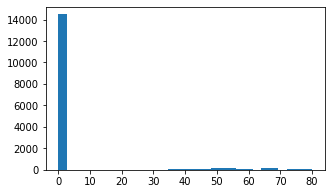

In [68]:
data.ASP.hist(grid=False, figsize=(5, 3), bins=30)

<AxesSubplot:>

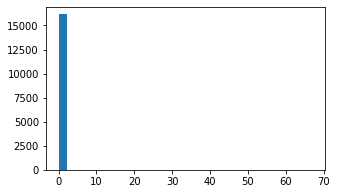

In [71]:
data['ASP_(converted)'].hist(grid=False, figsize=(5, 3), bins=30)

In [72]:
print('ASP_(converted) max:', data['ASP_(converted)'].max())
print('ASP_(converted) min:', data['ASP_(converted)'].min())

ASP_(converted) max: 67.0
ASP_(converted) min: 0.0


In [73]:
(data.ASP == data['ASP_(converted)']).sum()

8600

In [74]:
data.ASP_Currency.value_counts()

USD    8868
EUR    5337
JPY    4668
AUD     556
GBP       5
Name: ASP_Currency, dtype: int64

Se mantienen 8600 valores iguales en las columnas ASP y ASP_(converted)

Muy probable que sean valores de Currency USD (8868), los otros precios se convirtieron

In [65]:
data['ASP_(converted)'].nlargest(5)

2200     67.00000
2179     57.68578
1333     40.71938
16114     1.70000
16117     1.60000
Name: ASP_(converted), dtype: float64

In [97]:
# Cambio esos 3 outliers por el promedio del resto de la columna de los dos sets
data_asp_mean = data[data['ASP_(converted)'] <= 10]['ASP_(converted)'].mean()
outliers =  data['ASP_(converted)'] <= 10
data['ASP_(converted)'] = data['ASP_(converted)'].where(outliers, data_asp_mean)

<AxesSubplot:>

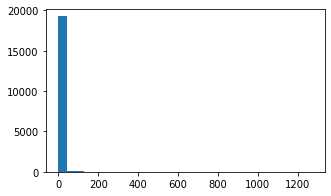

In [86]:
data['TRF'].hist(grid=False, figsize=(5, 3), bins=30)

In [88]:
data['TRF'].nlargest(20)

1345     1272
1367      502
16682     500
7364      429
3667      400
16616     400
1631      330
15467     270
2806      250
1078      248
15466     195
1449      180
4156      180
14898     180
6677      175
6678      175
1445      175
6544      167
6232      165
6233      163
Name: TRF, dtype: int64

In [98]:
# Cambio el mas grande por el promedio del resto de la columna de los dos sets
data_trf_mean = math.floor(data[data['TRF'] < 600]['TRF'].mean())
outliers =  data['TRF'] < 600
data['TRF'] = data['TRF'].where(outliers, data_trf_mean)

In [113]:
# Del Tp1

# https://data.oecd.org/conversion/exchange-rates.htm
price_usd_convertion_by_year = {
    'EUR': {2016: 0.940, 2017: 0.923, 2018: 0.848, 2019: 0.893, 2020: 0.860},
    'JPY': {2016: 113.138, 2017: 116.667, 2018: 110.424, 2019: 109.008, 2020: 104.66},
    'AUD': {2016: 1.400, 2017: 1.358, 2018: 1.340, 2019: 1.439, 2020: 1.420},
    'GBP': {2016: 0.770, 2017: 0.808, 2018: 0.750, 2019: 0.784, 2020: 0.770},
    'USD': {2016: 1, 2017: 1, 2018: 1, 2019: 1, 2020: 1}
}

def get_convertion_usd(x):
    currency = x['Total_Amount_Currency']
    year = pd.to_datetime(x['Month']).year
    return price_usd_convertion_by_year[currency][year]
    
data['Total_Amount_Converted'] = data['Total_Amount'] / data.apply(lambda x: get_convertion_usd(x), axis=1)

def get_total_convertion_usd(x):
    currency = x['Total_Taxable_Amount_Currency']
    year = pd.to_datetime(x['Month']).year
    return price_usd_convertion_by_year[currency][year]
    
data['Total_Taxable_Amount_Converted'] = data['Total_Taxable_Amount'] / data.apply(lambda x: get_convertion_usd(x), axis=1)


<AxesSubplot:>

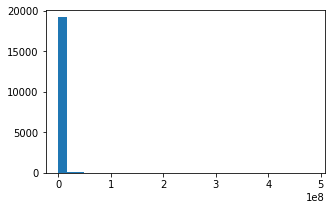

In [123]:
data['Total_Amount_Converted'].hist(grid=False, figsize=(5, 3), bins=30)

<AxesSubplot:>

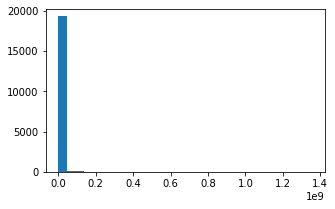

In [127]:
data['Total_Taxable_Amount_Converted'].hist(grid=False, figsize=(5, 3), bins=30)

In [132]:
data_prices = data.groupby('Opportunity_ID').agg(\
    {'ASP_(converted)':['max','mean','min'],\
     'TRF': ['max','mean','min'],\
     'Total_Amount_Converted':['max','mean','min'], \
     'Total_Taxable_Amount_Converted': ['mean']}).reset_index()
data_prices

Opportunity_ID ASP_(converted)                     TRF              \
                                 max     mean      min   max  mean   min   
0                  0         0.58817  0.58817  0.58817  10.0  10.0  10.0   
1                  1         0.59948  0.59948  0.59948   0.0   0.0   0.0   
2                  2         0.48000  0.48000  0.48000   0.0   0.0   0.0   
3                  3         0.53000  0.53000  0.53000  14.0  14.0  14.0   
4                  4         0.53000  0.53000  0.53000  25.0  25.0  25.0   
...              ...             ...      ...      ...   ...   ...   ...   
11353          12799         0.58251  0.58251  0.58251   1.0   1.0   1.0   
11354          12800         0.53000  0.53000  0.53000  20.0  20.0  20.0   
11355          12801         0.58817  0.58817  0.58817   0.0   0.0   0.0   
11356          12802         0.63750  0.63750  0.63750   4.0   4.0   4.0   
11357          12803         0.64000  0.64000  0.64000  40.0  40.0  40.0   

      Total_Amount_Converted                              \
                         max          mean           min   
0               5.609362e+06  5.609362e+06  5.609362e+06   
1               5.130851e+04  5.130851e+04  5.130851e+04   
2               8.386560e+04  8.386560e+04  8.386560e+04   
3               7.421882e+06  7.421882e+06  7.421882e+06   
4               1.335719e+07  1.335719e+07  1.335719e+07   
...                      ...           ...           ...   
11353           4.273404e+05  4.273404e+05  4.273404e+05   
11354           1.075158e+07  1.066625e+07  1.058092e+07   
11355           1.099468e+05  1.062819e+05  9.895213e+04   
11356           2.346797e+06  2.346797e+06  2.346797e+06   
11357           2.560320e+07  2.560320e+07  2.560320e+07   

      Total_Taxable_Amount_Converted  
                                mean  
0                       5.609362e+06  
1                       5.130851e+04  
2                       8.386560e+04  
3                       7.421882e+06  
4                       1.335719e+07  
...                              ...  
11353                   4.273404e+05  
11354                   2.133250e+07  
11355                   3.188457e+05  
11356                   0.000000e+00  
11357                   0.000000e+00  

[11358 rows x 11 columns]

In [130]:
# Features

X['ASP_(converted)_mean'] = data_prices['ASP_(converted)']['mean']
X['TRF_mean'] = data_prices['TRF']['mean']
X['Total_Amount_Converted_mean'] = data_prices['Total_Amount_Converted']['mean']

In [131]:
X['ASP_(converted)_max_min'] = \
    data_prices['ASP_(converted)']['max'] - data_prices['ASP_(converted)']['min']
X['TRF_max_min'] = \
    data_prices['TRF']['max'] - data_prices['TRF']['min']
X['Total_Amount_Converted_max_min'] = \
    data_prices['Total_Amount_Converted']['max'] - data_prices['Total_Amount_Converted']['min']

In [134]:
X['Total_Taxable_Amount_Converted'] = data_prices['Total_Taxable_Amount_Converted']['mean']

In [140]:
X['Total_Amount_Converted_>100'] = (X['Total_Amount_Converted_mean'] > 100000).astype('int8')

In [149]:
X['ASP_(converted)_mean'].describe()

count    11358.000000
mean         0.416840
std          0.101272
min          0.000000
25%          0.370000
50%          0.412850
75%          0.456842
max          1.700000
Name: ASP_(converted)_mean, dtype: float64

In [202]:
# Binning
X['ASP_bins'] = pd.cut(X["ASP_(converted)_mean"], \
                           bins=[-0.1, 0.2, 0.4, 0.6, 0.8, 1, 1.5], \
                           labels=[1,2,3,4,5,6]) 
X['ASP_bins']

0        3
1        3
2        3
3        3
4        3
        ..
11353    3
11354    3
11355    3
11356    4
11357    4
Name: ASP_bins, Length: 11358, dtype: category
Categories (6, int64): [1 < 2 < 3 < 4 < 5 < 6]

In [151]:
X['TRF_mean'].describe()

count    11358.000000
mean         2.882071
std         14.972947
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max        502.000000
Name: TRF_mean, dtype: float64

In [153]:
X['TRF_mean'].sample(20)

10816     1.000000
3007      0.000000
7116      0.000000
7603      1.000000
7562     10.000000
711       0.000000
4955     63.000000
10127     0.500000
8289      1.000000
7974     20.000000
5728      0.000000
10222     0.000000
3606      1.000000
7463      2.666667
6120      0.000000
5778      1.000000
1279      0.000000
5477      1.000000
443       0.000000
1801      2.500000
Name: TRF_mean, dtype: float64

In [198]:
pd.cut(X["TRF_mean"], \
                           bins=[-0.1,0.1,1,3,10,600], \
                           labels=[0,1,2,3,4]).value_counts()

0    7021
1    2062
2     861
3     808
4     606
Name: TRF_mean, dtype: int64

In [236]:
# Binning
X["TRF_bins"] = pd.cut(X["TRF_mean"], \
                           bins=[-0.1,0.1,1,3,10,600], \
                           labels=[0,1,2,3,4])

In [200]:
X['Total_Amount_Converted_mean'].describe()

count    1.131000e+04
mean     1.274441e+06
std      8.475557e+06
min      0.000000e+00
25%      3.699402e+04
50%      1.020918e+05
75%      3.912147e+05
max      4.832840e+08
Name: Total_Amount_Converted_mean, dtype: float64

In [230]:
pd.cut(X["Total_Amount_Converted_mean"], \
             bins=[-0.1,10000,50000,90000,180000,400000,1000000,1000000000], \
             labels=[0,1,2,3,4,5,6]).value_counts()

2    1836
1    1809
3    1796
6    1674
0    1544
4    1537
5    1114
Name: Total_Amount_Converted_mean, dtype: int64

In [237]:
# Binning
X["Total_Amount_Converted_bins"] = pd.cut(X["Total_Amount_Converted_mean"], \
             bins=[-0.1,10000,50000,90000,180000,400000,1000000,1000000000], \
             labels=[0,1,2,3,4,5,6])

In [232]:
X

,Opportunity_ID,ASP_(converted)_mean,TRF_mean,Total_Amount_Converted_mean,ASP_(converted)_max_min,TRF_max_min,Total_Amount_Converted_max_min,Total_Taxable_Amount_Converted,Total_Amount_Converted_>100,ASP_bins,TRF_bins,Total_Amount_Converted_bins
0,0,0.58817,10.0,5.609362e+06,0.0,0.0,0.000000,5.609362e+06,1,3,7021.0,1544.0
1,1,0.59948,0.0,5.130851e+04,0.0,0.0,0.000000,5.130851e+04,0,3,2062.0,1809.0
2,2,0.48000,0.0,8.386560e+04,0.0,0.0,0.000000,8.386560e+04,0,3,861.0,1836.0
3,3,0.53000,14.0,7.421882e+06,0.0,0.0,0.000000,7.421882e+06,1,3,808.0,1796.0
4,4,0.53000,25.0,1.335719e+07,0.0,0.0,0.000000,1.335719e+07,1,3,606.0,1537.0
...,...,...,...,...,...,...,...,...,...,...,...,...
11353,12364,0.58251,1.0,4.273404e+05,0.0,0.0,0.000000,4.273404e+05,1,3,NaN,NaN
11354,12365,0.53000,20.0,1.066625e+07,0.0,0.0,170660.000000,2.133250e+07,1,3,NaN,NaN
11355,12366,0.58817,0.0,1.062819e+05,0.0,0.0,10994.680851,3.188457e+05,1,3,NaN,NaN
11356,12367,0.63750,4.0,2.346797e+06,0.0,0.0,0.000000,0.000000e+00,1,4,NaN,NaN


In [238]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11358 entries, 0 to 11357
Data columns (total 12 columns):
 #   Column                          Non-Null Count  Dtype   
---  ------                          --------------  -----   
 0   Opportunity_ID                  11358 non-null  int64   
 1   ASP_(converted)_mean            11358 non-null  float64 
 2   TRF_mean                        11358 non-null  float64 
 3   Total_Amount_Converted_mean     11310 non-null  float64 
 4   ASP_(converted)_max_min         11358 non-null  float64 
 5   TRF_max_min                     11358 non-null  float64 
 6   Total_Amount_Converted_max_min  11310 non-null  float64 
 7   Total_Taxable_Amount_Converted  11358 non-null  float64 
 8   Total_Amount_Converted_>100     11358 non-null  int8    
 9   ASP_bins                        11356 non-null  category
 10  TRF_bins                        11358 non-null  category
 11  Total_Amount_Converted_bins     11310 non-null  category
dtypes: category(3), fl

In [243]:
X['Total_Amount_Converted_mean']\
    .fillna(X['Total_Amount_Converted_mean'].mean(), inplace=True)

X['Total_Amount_Converted_max_min']\
    .fillna(X['Total_Amount_Converted_max_min'].mean(), inplace=True)

X['ASP_bins'].fillna(math.floor(X['ASP_bins'].mode()), inplace=True)

X['Total_Amount_Converted_bins']\
    .fillna(math.floor(X['Total_Amount_Converted_bins'].mode()), inplace=True)

In [246]:
X['ASP_bins'] = X['ASP_bins'].astype('int8')
X['TRF_bins'] = X['TRF_bins'].astype('int8')
X['Total_Amount_Converted_bins'] = X['Total_Amount_Converted_bins'].astype('int8')

In [297]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11358 entries, 0 to 11357
Data columns (total 13 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Opportunity_ID                  11358 non-null  int64  
 1   ASP_(converted)_mean            11358 non-null  float64
 2   TRF_mean                        11358 non-null  float64
 3   Total_Amount_Converted_mean     11358 non-null  float64
 4   ASP_(converted)_max_min         11358 non-null  float64
 5   TRF_max_min                     11358 non-null  float64
 6   Total_Amount_Converted_max_min  11358 non-null  float64
 7   Total_Taxable_Amount_Converted  11358 non-null  float64
 8   Total_Amount_Converted_>100     11358 non-null  int8   
 9   ASP_bins                        11358 non-null  int8   
 10  TRF_bins                        11358 non-null  int8   
 11  Total_Amount_Converted_bins     11358 non-null  int8   
 12  has_price                       

### Me quedo con los features de mayor importancia

In [298]:
train_ids = train.Opportunity_ID.unique()
trainX = X[X['Opportunity_ID'].isin(train_ids)]
trainX

,Opportunity_ID,ASP_(converted)_mean,TRF_mean,Total_Amount_Converted_mean,ASP_(converted)_max_min,TRF_max_min,Total_Amount_Converted_max_min,Total_Taxable_Amount_Converted,Total_Amount_Converted_>100,ASP_bins,TRF_bins,Total_Amount_Converted_bins,has_price
0,0,0.588170,10.0,5.609362e+06,0.00,0.0,0.00,5.609362e+06,1,3,3,6,0
1,1,0.599480,0.0,5.130851e+04,0.00,0.0,0.00,5.130851e+04,0,3,0,2,0
2,2,0.480000,0.0,8.386560e+04,0.00,0.0,0.00,8.386560e+04,0,3,0,2,0
3,3,0.530000,14.0,7.421882e+06,0.00,0.0,0.00,7.421882e+06,1,3,4,6,1
4,4,0.530000,25.0,1.335719e+07,0.00,0.0,0.00,1.335719e+07,1,3,4,6,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9786,12799,0.427894,0.0,7.385810e+03,0.09,0.0,14007.87,2.215743e+04,0,3,0,0,0
9787,12800,0.440000,0.0,4.181760e+04,0.00,0.0,0.00,4.181760e+04,0,3,0,1,0
9788,12801,0.370000,1.0,2.008656e+05,0.00,0.0,0.00,8.034624e+05,1,2,1,4,0
9789,12802,0.370000,1.0,4.031261e+05,0.00,0.0,94853.20,1.612504e+06,1,2,1,5,0


In [251]:
y = train.groupby('Opportunity_ID')['Stage'].min()
y

Opportunity_ID
0        0
1        1
2        1
3        0
4        0
        ..
12799    1
12800    0
12801    1
12802    0
12803    0
Name: Stage, Length: 9791, dtype: int64

In [252]:
(y.index != trainX.Opportunity_ID).sum()

0

In [299]:
test_ids = test.Opportunity_ID.unique()
testX = X[X['Opportunity_ID'].isin(test_ids)]
testX

,Opportunity_ID,ASP_(converted)_mean,TRF_mean,Total_Amount_Converted_mean,ASP_(converted)_max_min,TRF_max_min,Total_Amount_Converted_max_min,Total_Taxable_Amount_Converted,Total_Amount_Converted_>100,ASP_bins,TRF_bins,Total_Amount_Converted_bins,has_price
9791,10689,0.28277,0.0,6.223404e+04,0.00,0.0,0.000000,6.223404e+04,0,2,0,2,0
9792,10690,0.28500,2.0,5.135130e+05,0.00,0.0,0.000000,5.135130e+05,1,2,2,5,1
9793,10691,0.39000,0.0,1.061775e+05,0.00,0.0,0.000000,1.061775e+05,1,2,0,3,0
9794,10692,0.34000,0.0,1.178100e+04,0.00,0.0,0.000000,1.178100e+04,0,2,0,1,0
9795,10693,0.26500,0.5,1.475925e+05,0.03,1.0,36465.000000,2.951850e+05,1,2,1,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11353,12364,0.58251,1.0,4.273404e+05,0.00,0.0,0.000000,4.273404e+05,1,3,1,5,0
11354,12365,0.53000,20.0,1.066625e+07,0.00,0.0,170660.000000,2.133250e+07,1,3,4,6,0
11355,12366,0.58817,0.0,1.062819e+05,0.00,0.0,10994.680851,3.188457e+05,1,3,0,3,0
11356,12367,0.63750,4.0,2.346797e+06,0.00,0.0,0.000000,0.000000e+00,1,4,3,6,0


In [300]:
df_train = trainX.drop('Opportunity_ID', axis=1).copy()

In [270]:
import random

s = pd.Series('Random')

for i in range (0, train.Opportunity_ID.nunique()):
    s[i] = random.randint(0,10000)
s

0       6191
1       6159
2       3455
3       1603
4       6441
        ... 
9786     681
9787    3419
9788    7006
9789     497
9790    1922
Length: 9791, dtype: object

In [301]:
df_train['Random'] = s.astype('int64')

In [302]:
df_train

,ASP_(converted)_mean,TRF_mean,Total_Amount_Converted_mean,ASP_(converted)_max_min,TRF_max_min,Total_Amount_Converted_max_min,Total_Taxable_Amount_Converted,Total_Amount_Converted_>100,ASP_bins,TRF_bins,Total_Amount_Converted_bins,has_price,Random
0,0.588170,10.0,5.609362e+06,0.00,0.0,0.00,5.609362e+06,1,3,3,6,0,6191
1,0.599480,0.0,5.130851e+04,0.00,0.0,0.00,5.130851e+04,0,3,0,2,0,6159
2,0.480000,0.0,8.386560e+04,0.00,0.0,0.00,8.386560e+04,0,3,0,2,0,3455
3,0.530000,14.0,7.421882e+06,0.00,0.0,0.00,7.421882e+06,1,3,4,6,1,1603
4,0.530000,25.0,1.335719e+07,0.00,0.0,0.00,1.335719e+07,1,3,4,6,1,6441
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9786,0.427894,0.0,7.385810e+03,0.09,0.0,14007.87,2.215743e+04,0,3,0,0,0,681
9787,0.440000,0.0,4.181760e+04,0.00,0.0,0.00,4.181760e+04,0,3,0,1,0,3419
9788,0.370000,1.0,2.008656e+05,0.00,0.0,0.00,8.034624e+05,1,2,1,4,0,7006
9789,0.370000,1.0,4.031261e+05,0.00,0.0,94853.20,1.612504e+06,1,2,1,5,0,497


In [303]:
# Calculo el error
X_train, X_test, y_train, y_test = \
    train_test_split(df_train, y, test_size=0.2, random_state=123)

rf_reg = RandomForestRegressor(n_estimators=100)
rf_reg.fit(X_train, y_train)
preds = rf_reg.predict(X_test)
ll = log_loss(y_test, preds, normalize=True)
print("Log Loss: %f" % (ll))

Log Loss: 0.663703


In [304]:
# Feature importances
rf_reg.feature_importances_

array([0.17002788, 0.08863503, 0.2824102 , 0.0413648 , 0.00204179,
       0.03960165, 0.13320758, 0.00048385, 0.00564759, 0.00161345,
       0.00437265, 0.02267489, 0.20791865])

In [305]:
p = pd.DataFrame({'feature':X_train.columns, 'value':rf_reg.feature_importances_})

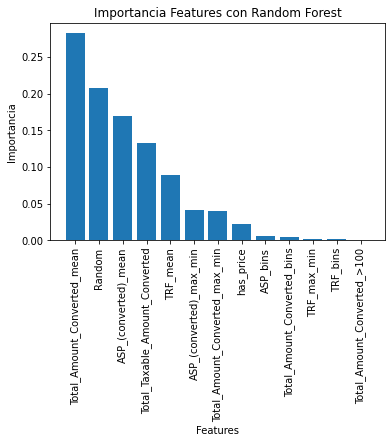

In [306]:
g = p.sort_values('value').nlargest(50, 'value')

plt.bar(g.feature, g.value, )
plt.xlabel('Features')
plt.xticks(rotation=90)
plt.ylabel('Importancia')
plt.title('Importancia Features con Random Forest')
plt.show()

In [307]:
# La unica columna relevante es Total_Amount_Converted_mean
# La forma de calcularla es 

# https://data.oecd.org/conversion/exchange-rates.htm
price_usd_convertion_by_year = {
    'EUR': {2016: 0.940, 2017: 0.923, 2018: 0.848, 2019: 0.893, 2020: 0.860},
    'JPY': {2016: 113.138, 2017: 116.667, 2018: 110.424, 2019: 109.008, 2020: 104.66},
    'AUD': {2016: 1.400, 2017: 1.358, 2018: 1.340, 2019: 1.439, 2020: 1.420},
    'GBP': {2016: 0.770, 2017: 0.808, 2018: 0.750, 2019: 0.784, 2020: 0.770},
    'USD': {2016: 1, 2017: 1, 2018: 1, 2019: 1, 2020: 1}
}

def get_convertion_usd(x):
    currency = x['Total_Amount_Currency']
    year = pd.to_datetime(x['Month']).year
    return price_usd_convertion_by_year[currency][year]
    
data['Total_Amount_Converted'] = data['Total_Amount'] / data.apply(lambda x: get_convertion_usd(x), axis=1)


data_prices = data.groupby('Opportunity_ID').agg(\
    {'Total_Amount_Converted':'mean'}).reset_index()


X['Total_Amount_Converted_mean'] = data_prices['Total_Amount_Converted']